In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [33]:
df_fr = pd.read_csv("../data/french_data.csv")
df_be = pd.read_csv("../data/belgium_data.csv")
df_eu = pd.read_csv("../data/european_data.csv")

🔄 Chargement des données...
🔄 Préparation des mini-batches...
🔄 Initialisation des clients...
🚀 Démarrage de l'entraînement fédéré...

📊 Round 1/10
   🔹 AUC France: 0.5995
   🔹 AUC Belgique: 0.5081
   🔹 AUC Europe: 0.6255
   🔶 AUC Global: 0.6236
   📈 Exposure: 0.8579
   📈 Power: -0.0382
   📈 DriverAge: 0.0679
   📈 Fuel_type: 0.1908
   📈 Density: -0.1821
   📈 Sex: 0.1436
   📉 Intercept: -0.7873

📊 Round 2/10
   🔹 AUC France: 0.5963
   🔹 AUC Belgique: 0.5395
   🔹 AUC Europe: 0.6359
   🔶 AUC Global: 0.6319
   📈 Exposure: 1.0363
   📈 Power: 0.1801
   📈 DriverAge: 0.0153
   📈 Fuel_type: 0.2173
   📈 Density: -0.0480
   📈 Sex: -0.0179
   📉 Intercept: -0.9099

📊 Round 3/10
   🔹 AUC France: 0.6039
   🔹 AUC Belgique: 0.5659
   🔹 AUC Europe: 0.6350
   🔶 AUC Global: 0.6345
   📈 Exposure: 1.0435
   📈 Power: 0.0075
   📈 DriverAge: -0.0480
   📈 Fuel_type: 0.1381
   📈 Density: 0.2306
   📈 Sex: -0.1017
   📉 Intercept: -0.9166

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5701
   🔹 AUC Euro

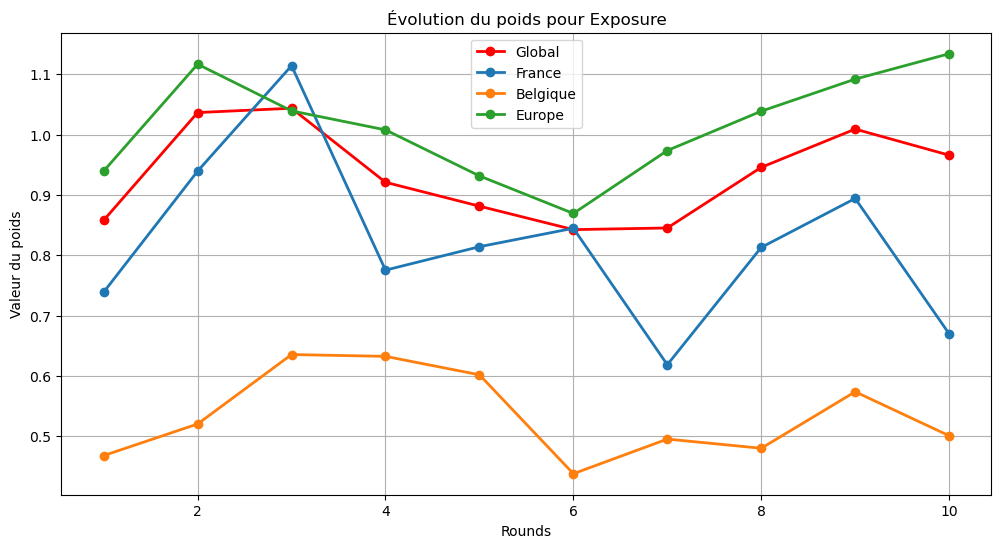

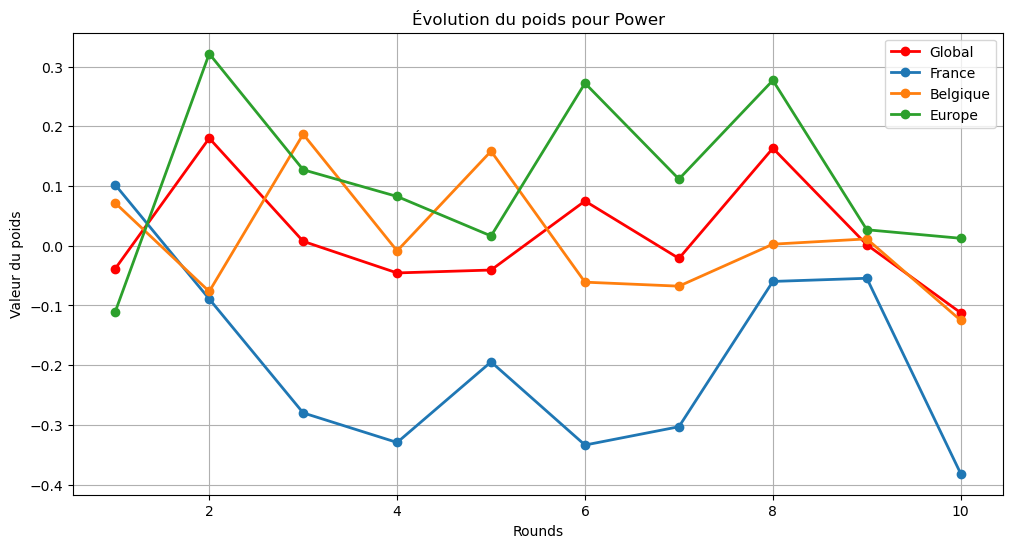

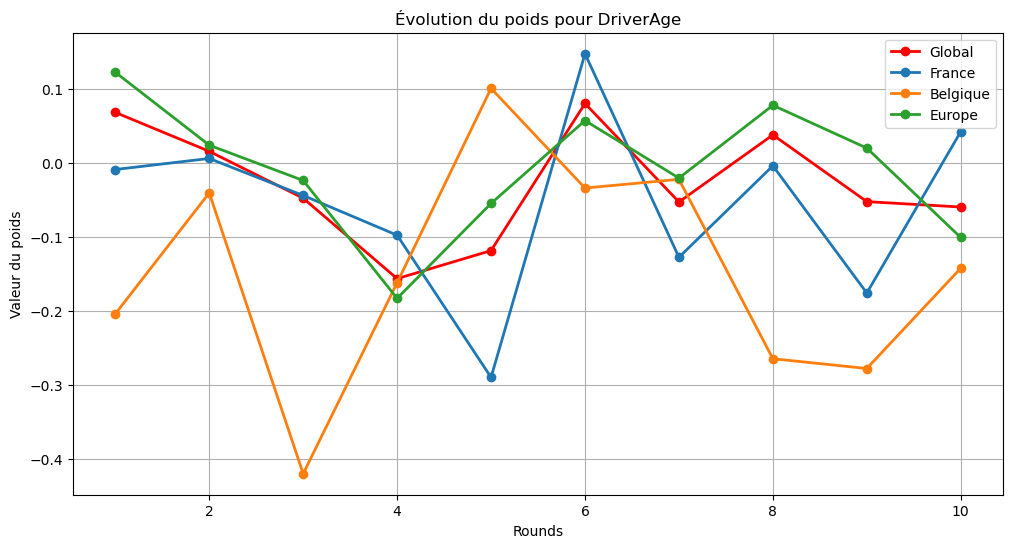

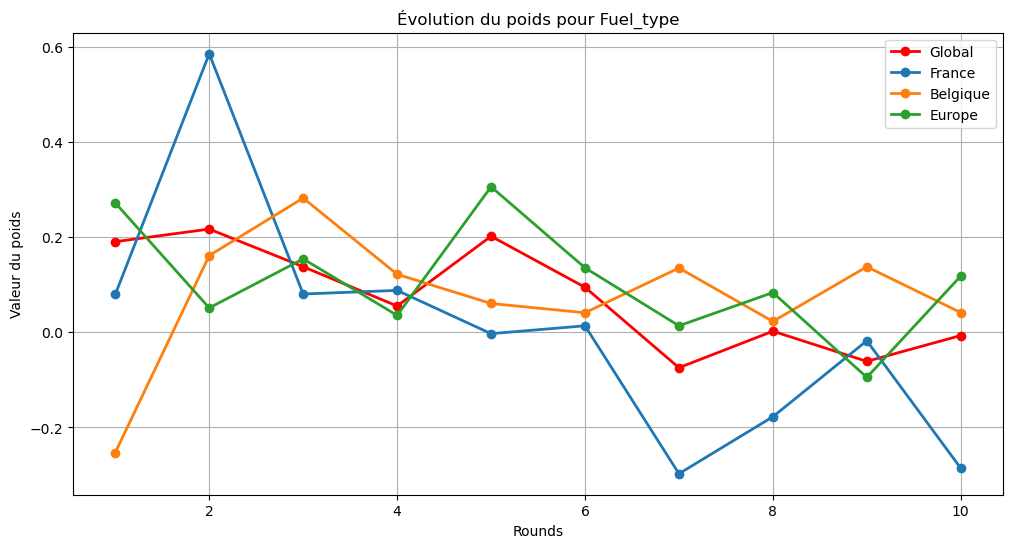

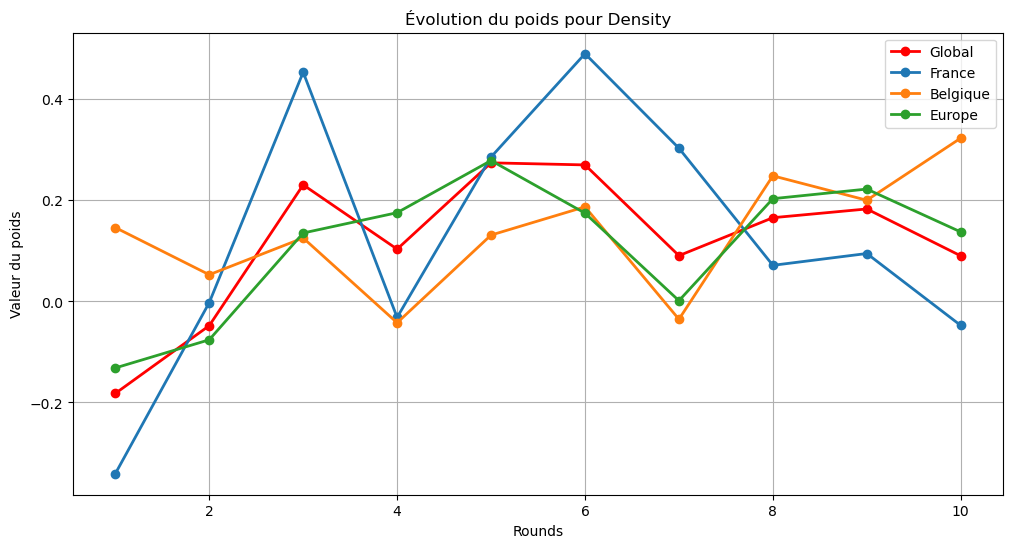

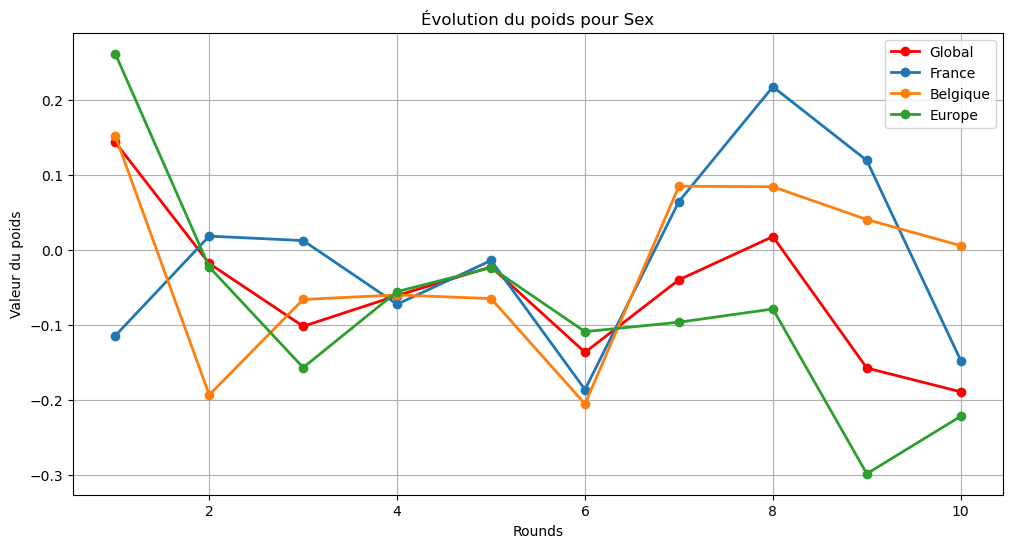

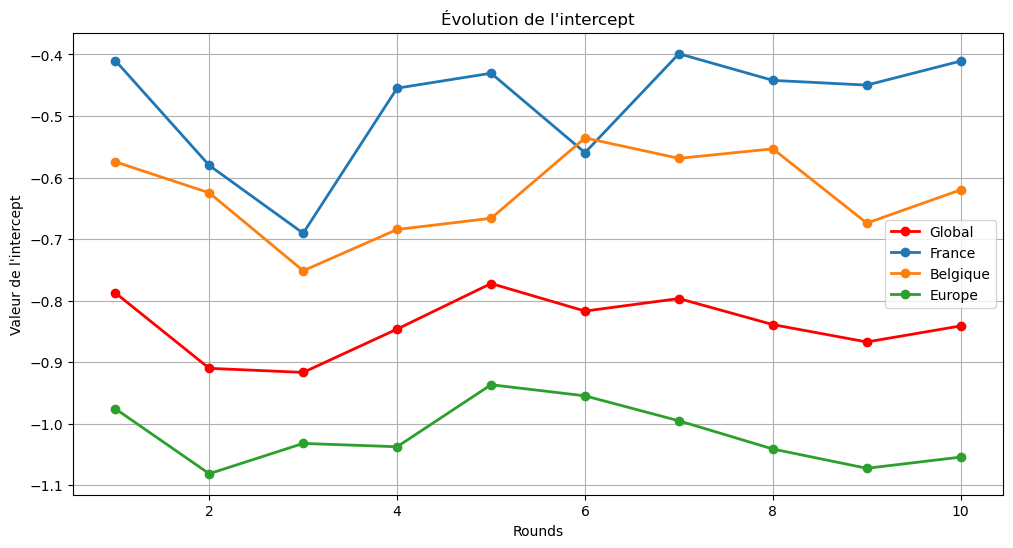

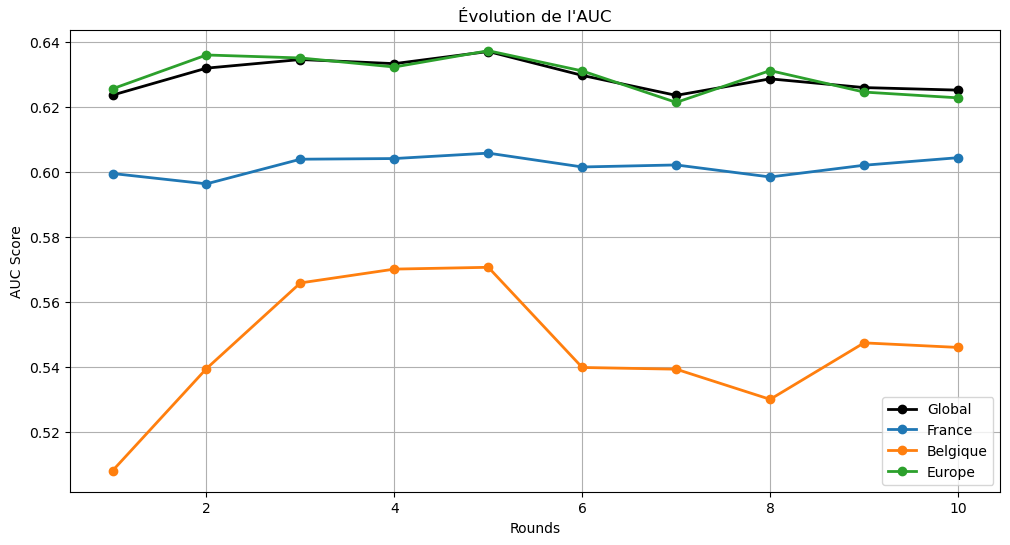

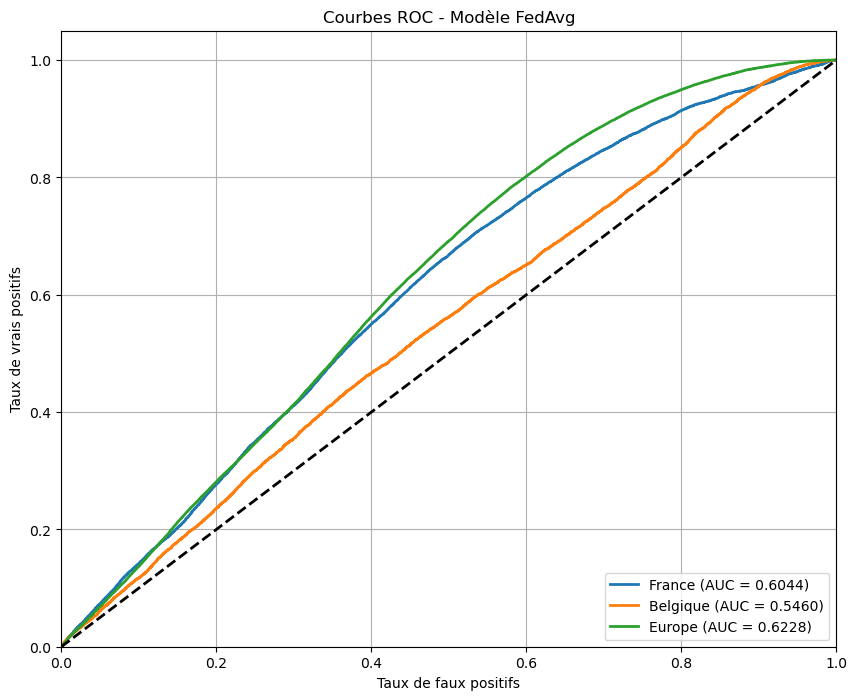

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Préparation des données avec stratification des classes
def prepare_client_data(df, n_rounds, features=["Exposure", "Power", "DriverAge", "Fuel_type", "Density", "Sex"], 
                        target="Sinistre", test_size=0.4):
    """Prépare les données client avec des mini-batches équilibrés"""
    X = df[features].values
    y = df[target].values
    
    # Split train/test stratifié
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        stratify=y, random_state=42)
    
    # Standardisation (sauf Exposure)
    scaler = StandardScaler()
    X_train_std = np.hstack([
        X_train[:, 0:1],  # Garder Exposure non standardisée
        scaler.fit_transform(X_train[:, 1:])  # Standardiser les autres features
    ])
    
    X_test_std = np.hstack([
        X_test[:, 0:1],  # Garder Exposure non standardisée
        scaler.transform(X_test[:, 1:])  # Standardiser avec le même scaler
    ])
    
    # Créer des mini-batches stratifiés
    indices_class0 = np.where(y_train == 0)[0]
    indices_class1 = np.where(y_train == 1)[0]
    
    np.random.shuffle(indices_class0)
    np.random.shuffle(indices_class1)
    
    batch_size_0 = len(indices_class0) // n_rounds
    batch_size_1 = max(1, len(indices_class1) // n_rounds)  # Au moins 1 exemple positif
    
    batches = []
    for i in range(n_rounds):
        # Sélectionner des indices pour les deux classes
        start0 = i * batch_size_0
        end0 = min((i + 1) * batch_size_0, len(indices_class0))
        
        start1 = i * batch_size_1
        end1 = min((i + 1) * batch_size_1, len(indices_class1))
        
        batch_indices = np.concatenate([
            indices_class0[start0:end0],
            indices_class1[start1:end1] if start1 < len(indices_class1) else []
        ])
        
        X_batch = X_train_std[batch_indices]
        y_batch = y_train[batch_indices]
        
        batches.append((X_batch, y_batch))
    
    return batches, X_test_std, y_test

# 2. Client FedAvg
class FedAvgClient:
    def __init__(self, data_batches, client_id, local_epochs=3):
        """Initialise un client d'apprentissage fédéré"""
        self.client_id = client_id
        self.batches = data_batches
        self.n_rounds = len(data_batches)
        self.local_epochs = local_epochs
        self.n_samples = sum(len(batch[0]) for batch in data_batches)
        
        # Initialiser le modèle avec le contrôle de l'intercept
        self.model = SGDClassifier(
            loss="log_loss",
            penalty="l2",
            alpha=0.01,  # Régularisation L2
            learning_rate="constant",
            eta0=0.01,    # Taux d'apprentissage
            class_weight='balanced',  # Important pour données déséquilibrées
            max_iter=1,
            warm_start=True,
            random_state=42
        )
        
        # Initialisation manuelle des coefficients
        n_features = data_batches[0][0].shape[1]
        self.model.classes_ = np.array([0, 1])
        self.model.coef_ = np.zeros((1, n_features))
        self.model.intercept_ = np.zeros(1)
        
        # Historique des poids
        self.weight_history = {'coef': [], 'intercept': []}
        
        # Imputer pour gérer les valeurs manquantes
        self.imputer = SimpleImputer(strategy='mean')
    
    def train_local_model(self, global_model, round_idx):
        """Entraîne le modèle local avec plusieurs époques sur le batch du round actuel"""
        # Copier les poids du modèle global
        if global_model is not None:
            self.model.coef_ = np.copy(global_model.coef_)
            self.model.intercept_ = np.copy(global_model.intercept_)
        
        # Récupérer le batch pour ce round
        X_batch, y_batch = self.batches[round_idx]
        
        # Vérifier les classes présentes
        unique_classes = np.unique(y_batch)
        if len(unique_classes) < 2:
            print(f"⚠️ Batch {round_idx} du client {self.client_id} contient uniquement la classe {unique_classes[0]}")
            return self.model
        
        # Imputations si nécessaire
        if np.isnan(X_batch).any():
            X_batch = self.imputer.fit_transform(X_batch)
        
        # Entraînement local avec E époques
        for _ in range(self.local_epochs):
            self.model.partial_fit(X_batch, y_batch, classes=[0, 1])
            
            # Stabilisation de l'intercept
            if abs(self.model.intercept_[0]) > 5:
                self.model.intercept_[0] = np.clip(self.model.intercept_[0], -5, 5)
        
        # Enregistrer les poids après entraînement
        self.weight_history['coef'].append(np.copy(self.model.coef_[0]))
        self.weight_history['intercept'].append(np.copy(self.model.intercept_[0]))
        
        return self.model

# 3. Serveur FedAvg
class FedAvgServer:
    def __init__(self, clients, feature_names, clip_intercept=True):
        """Initialise le serveur d'agrégation"""
        self.clients = clients
        self.n_rounds = clients[0].n_rounds
        self.feature_names = feature_names
        self.clip_intercept = clip_intercept
        
        # Modèle global
        self.global_model = SGDClassifier(
            loss="log_loss",
            penalty="l2",
            alpha=0.01,
            class_weight='balanced',
            max_iter=1,
            warm_start=True,
            random_state=42
        )
        
        # Initialisation
        n_features = clients[0].batches[0][0].shape[1]
        self.global_model.classes_ = np.array([0, 1])
        self.global_model.coef_ = np.zeros((1, n_features))
        self.global_model.intercept_ = np.zeros(1)
        
        # Historique
        self.weight_history = {'coef': [], 'intercept': []}
        self.auc_history = {client.client_id: [] for client in clients}
        self.auc_history['Global'] = []
    
    def aggregate_models(self, models, weights):
        """Agrège les modèles locaux en modèle global"""
        avg_coef = np.zeros_like(models[0].coef_)
        avg_intercept = np.zeros_like(models[0].intercept_)
        
        total_weight = sum(weights)
        for model, weight in zip(models, weights):
            avg_coef += (weight / total_weight) * model.coef_
            avg_intercept += (weight / total_weight) * model.intercept_
        
        self.global_model.coef_ = avg_coef
        
        # Contrôler l'intercept
        if self.clip_intercept:
            self.global_model.intercept_ = np.clip(avg_intercept, -5, 5)
        else:
            self.global_model.intercept_ = avg_intercept
        
        return self.global_model
    
    def train(self, X_test_dict, y_test_dict):
        """Exécute l'entraînement fédéré et imprime les résultats par round"""
        imputer = SimpleImputer(strategy='mean')
        
        for round_idx in range(self.n_rounds):
            print(f"\n📊 Round {round_idx+1}/{self.n_rounds}")
            
            # Entraînement local
            local_models = []
            weights = []
            
            for client in self.clients:
                local_model = client.train_local_model(self.global_model, round_idx)
                local_models.append(local_model)
                weights.append(len(client.batches[round_idx][0]))
            
            # Agrégation
            self.global_model = self.aggregate_models(local_models, weights)
            
            # Enregistrer les poids globaux
            self.weight_history['coef'].append(np.copy(self.global_model.coef_[0]))
            self.weight_history['intercept'].append(np.copy(self.global_model.intercept_[0]))
            
            # Évaluation par client
            all_y_true = []
            all_y_pred = []
            
            for client in self.clients:
                X_test = X_test_dict[client.client_id]
                y_test = y_test_dict[client.client_id]
                
                # Imputation si nécessaire
                if np.isnan(X_test).any():
                    X_test_clean = imputer.fit_transform(X_test)
                else:
                    X_test_clean = X_test
                
                # Prédiction avec le modèle global, ajustée par l'exposition
                y_pred = self.global_model.predict_proba(X_test_clean)[:, 1] * X_test[:, 0]
                
                # Calcul de l'AUC
                auc = roc_auc_score(y_test, y_pred)
                self.auc_history[client.client_id].append(auc)
                print(f"   🔹 AUC {client.client_id}: {auc:.4f}")
                
                # Pour AUC global
                all_y_true.extend(y_test)
                all_y_pred.extend(y_pred)
            
            # AUC global
            global_auc = roc_auc_score(all_y_true, all_y_pred)
            self.auc_history['Global'].append(global_auc)
            print(f"   🔶 AUC Global: {global_auc:.4f}")
            
            # Afficher les coefficients
            for i, feature in enumerate(self.feature_names):
                print(f"   📈 {feature}: {self.global_model.coef_[0][i]:.4f}")
            print(f"   📉 Intercept: {self.global_model.intercept_[0]:.4f}")
        
        return self.global_model
    
    def plot_weight_evolution(self):
        """Visualise l'évolution des poids pour chaque feature"""
        for i, feature in enumerate(self.feature_names):
            plt.figure(figsize=(12, 6))
            
            # Poids globaux
            global_weights = [coef[i] for coef in self.weight_history['coef']]
            plt.plot(range(1, len(global_weights)+1), global_weights, 'r-o', linewidth=2, label='Global')
            
            # Poids locaux
            for client in self.clients:
                client_weights = [coef[i] for coef in client.weight_history['coef']]
                plt.plot(range(1, len(client_weights)+1), client_weights, '-o', linewidth=2, label=client.client_id)
            
            plt.xlabel('Rounds')
            plt.ylabel('Valeur du poids')
            plt.title(f'Évolution du poids pour {feature}')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # Plot pour l'intercept
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.weight_history['intercept'])+1), 
                self.weight_history['intercept'], 'r-o', linewidth=2, label='Global')
        
        for client in self.clients:
            plt.plot(range(1, len(client.weight_history['intercept'])+1), 
                    client.weight_history['intercept'], '-o', linewidth=2, label=client.client_id)
        
        plt.xlabel('Rounds')
        plt.ylabel('Valeur de l\'intercept')
        plt.title('Évolution de l\'intercept')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_auc_evolution(self):
        """Visualise l'évolution de l'AUC pour chaque client"""
        plt.figure(figsize=(12, 6))
        
        # AUC global
        plt.plot(range(1, len(self.auc_history['Global'])+1), 
                self.auc_history['Global'], 'k-o', linewidth=2, label='Global')
        
        # AUC par client
        for client_id, aucs in self.auc_history.items():
            if client_id != 'Global':
                plt.plot(range(1, len(aucs)+1), aucs, '-o', linewidth=2, label=client_id)
        
        plt.xlabel('Rounds')
        plt.ylabel('AUC Score')
        plt.title('Évolution de l\'AUC')
        plt.legend()
        plt.grid(True)
        plt.show()

# 4. Fonction principale
def run_federated_learning(n_rounds=10, local_epochs=3):
    """Exécute l'apprentissage fédéré complet avec visualisation"""
    print("🔄 Chargement des données...")
    
    df_fr = pd.read_csv("../data/french_data.csv").dropna()
    df_be = pd.read_csv("../data/belgium_data.csv").dropna()
    df_eu = pd.read_csv("../data/european_data.csv").dropna()
    
    feature_names = ["Exposure", "Power", "DriverAge", "Fuel_type", "Density", "Sex"]
    
    print("🔄 Préparation des mini-batches...")
    
    fr_batches, (X_fr_test, y_fr_test, exposure_fr_test) = prepare_client_data(df_fr, n_rounds, feature_names)
    be_batches, (X_be_test, y_be_test,exposure_be_test) = prepare_client_data(df_be, n_rounds, feature_names)
    eu_batches, (X_eu_test, y_eu_test, exposure_eu_test) = prepare_client_data(df_eu, n_rounds, feature_names)
    
    print("🔄 Initialisation des clients...")
    
    clients = [
        FedAvgClient(fr_batches, "France", local_epochs),
        FedAvgClient(be_batches, "Belgique", local_epochs),
        FedAvgClient(eu_batches, "Europe", local_epochs)
    ]
    
    server = FedAvgServer(clients, feature_names, clip_intercept=True)
    
    X_test_dict = {
        "France": X_fr_test,
        "Belgique": X_be_test,
        "Europe": X_eu_test
    }
    y_test_dict = {
        "France": y_fr_test,
        "Belgique": y_be_test,
        "Europe": y_eu_test
    }
    
    print("🚀 Démarrage de l'entraînement fédéré...")
    
    global_model = server.train(X_test_dict, y_test_dict)
    
    print("\n📊 Visualisation des résultats...")
    
    # Plots pour l'évolution des poids
    server.plot_weight_evolution()
    
    # Plot pour l'évolution de l'AUC
    server.plot_auc_evolution()
    
    # Plot de la courbe ROC finale
    plt.figure(figsize=(10, 8))
    for client_id, X_test in X_test_dict.items():
        y_test = y_test_dict[client_id]
        imputer = SimpleImputer(strategy='mean')
        
        if np.isnan(X_test).any():
            X_test = imputer.fit_transform(X_test)
            
        y_pred = global_model.predict_proba(X_test)[:, 1] * X_test[:, 0]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        
        plt.plot(fpr, tpr, lw=2, 
                 label=f'{client_id} (AUC = {roc_auc_score(y_test, y_pred):.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC - Modèle FedAvg')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return global_model, server

# Exécution du programme
if __name__ == "__main__":
    model, server = run_federated_learning(n_rounds=10, local_epochs=3)


In [58]:
# 1. Entraîner des modèles purement locaux (sans FL)
local_models = {}
for client_id in ["France", "Belgique", "Europe"]:
    local_model = SGDClassifier(
        loss="log_loss", 
        penalty="l2", 
        alpha=0.01,
        class_weight='balanced',
        max_iter=100,  # Plus d'itérations pour convergence locale
        random_state=42
    )
    # Récupérer les données d'entraînement locales complètes
    X_local = np.vstack([batch[0] for batch in clients_data[client_id]])
    y_local = np.hstack([batch[1] for batch in clients_data[client_id]])
    local_model.fit(X_local, y_local)
    local_models[client_id] = local_model

# 2. Évaluer tous les modèles sur tous les jeux de test
results = pd.DataFrame(columns=["Modèle", "Testé sur", "AUC"])

# Évaluation du modèle global sur chaque jeu de test
for client_id, X_test in X_test_dict.items():
    y_test = y_test_dict[client_id]
    y_pred = global_model.predict_proba(X_test)[:, 1] * X_test[:, 0]  # Ajustement Exposure
    auc = roc_auc_score(y_test, y_pred)
    results = results.append({"Modèle": "Global", "Testé sur": client_id, "AUC": auc}, ignore_index=True)

# Évaluation des modèles locaux sur chaque jeu de test
for model_id, model in local_models.items():
    for client_id, X_test in X_test_dict.items():
        y_test = y_test_dict[client_id]
        y_pred = model.predict_proba(X_test)[:, 1] * X_test[:, 0]
        auc = roc_auc_score(y_test, y_pred)
        results = results.append({"Modèle": model_id, "Testé sur": client_id, "AUC": auc}, ignore_index=True)

# 3. Visualiser les résultats
plt.figure(figsize=(12, 8))
sns.barplot(x="Testé sur", y="AUC", hue="Modèle", data=results)
plt.title("Comparaison des performances des modèles locaux vs global")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()


NameError: name 'clients_data' is not defined

--------------------------------


===== OPTIMISATION FEDAVG =====

📊 Round 1/10
   🔹 AUC France: 0.6040
   🔹 AUC Belgique: 0.5752
   🔹 AUC Europe: 0.6365
   🔶 AUC Global: 0.6364
   📈 Exposure: 0.8451
   📈 Power: 0.0021
   📈 DriverAge: -0.1858
   📈 Fuel_type: 0.1010
   📈 Density: 0.1693
   📈 Sex: 0.0182
   📉 Intercept: -0.7742

📊 Round 2/10
   🔹 AUC France: 0.5941
   🔹 AUC Belgique: 0.5512
   🔹 AUC Europe: 0.6375
   🔶 AUC Global: 0.6328
   📈 Exposure: 0.7967
   📈 Power: 0.2007
   📈 DriverAge: -0.1632
   📈 Fuel_type: 0.2110
   📈 Density: -0.1807
   📈 Sex: 0.0354
   📉 Intercept: -0.7973

📊 Round 3/10
   🔹 AUC France: 0.5958
   🔹 AUC Belgique: 0.5432
   🔹 AUC Europe: 0.6312
   🔶 AUC Global: 0.6283
   📈 Exposure: 1.0513
   📈 Power: 0.0654
   📈 DriverAge: -0.0950
   📈 Fuel_type: 0.1285
   📈 Density: -0.2381
   📈 Sex: 0.0015
   📉 Intercept: -0.9228

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5302
   🔹 AUC Europe: 0.6288
   🔶 AUC Global: 0.6284
   📈 Exposure: 1.1852
   📈 Power: -0.0584
   📈 DriverAge: 0.1130
  

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1)] before, using random point [np.int64(3)]
  warnings.warn(



📊 Round 1/10
   🔹 AUC France: 0.6040
   🔹 AUC Belgique: 0.5752
   🔹 AUC Europe: 0.6365
   🔶 AUC Global: 0.6364
   📈 Exposure: 0.8446
   📈 Power: 0.0021
   📈 DriverAge: -0.1857
   📈 Fuel_type: 0.1010
   📈 Density: 0.1693
   📈 Sex: 0.0182
   📉 Intercept: -0.7737

📊 Round 2/10
   🔹 AUC France: 0.5941
   🔹 AUC Belgique: 0.5512
   🔹 AUC Europe: 0.6375
   🔶 AUC Global: 0.6328
   📈 Exposure: 0.7970
   📈 Power: 0.2007
   📈 DriverAge: -0.1632
   📈 Fuel_type: 0.2110
   📈 Density: -0.1807
   📈 Sex: 0.0354
   📉 Intercept: -0.7976

📊 Round 3/10
   🔹 AUC France: 0.5958
   🔹 AUC Belgique: 0.5432
   🔹 AUC Europe: 0.6312
   🔶 AUC Global: 0.6283
   📈 Exposure: 1.0515
   📈 Power: 0.0654
   📈 DriverAge: -0.0950
   📈 Fuel_type: 0.1285
   📈 Density: -0.2381
   📈 Sex: 0.0015
   📉 Intercept: -0.9230

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5302
   🔹 AUC Europe: 0.6288
   🔶 AUC Global: 0.6284
   📈 Exposure: 1.1856
   📈 Power: -0.0584
   📈 DriverAge: 0.1130
   📈 Fuel_type: 0.1870
   📈 Density

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(4)]
  warnings.warn(



📊 Round 1/10
   🔹 AUC France: 0.6040
   🔹 AUC Belgique: 0.5752
   🔹 AUC Europe: 0.6365
   🔶 AUC Global: 0.6364
   📈 Exposure: 0.8451
   📈 Power: 0.0021
   📈 DriverAge: -0.1858
   📈 Fuel_type: 0.1010
   📈 Density: 0.1693
   📈 Sex: 0.0182
   📉 Intercept: -0.7742

📊 Round 2/10
   🔹 AUC France: 0.5941
   🔹 AUC Belgique: 0.5512
   🔹 AUC Europe: 0.6375
   🔶 AUC Global: 0.6328
   📈 Exposure: 0.7967
   📈 Power: 0.2007
   📈 DriverAge: -0.1632
   📈 Fuel_type: 0.2110
   📈 Density: -0.1807
   📈 Sex: 0.0354
   📉 Intercept: -0.7973

📊 Round 3/10
   🔹 AUC France: 0.5958
   🔹 AUC Belgique: 0.5432
   🔹 AUC Europe: 0.6312
   🔶 AUC Global: 0.6283
   📈 Exposure: 1.0513
   📈 Power: 0.0654
   📈 DriverAge: -0.0950
   📈 Fuel_type: 0.1285
   📈 Density: -0.2381
   📈 Sex: 0.0015
   📉 Intercept: -0.9228

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5302
   🔹 AUC Europe: 0.6288
   🔶 AUC Global: 0.6284
   📈 Exposure: 1.1852
   📈 Power: -0.0584
   📈 DriverAge: 0.1130
   📈 Fuel_type: 0.1870
   📈 Density

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1)] before, using random point [np.int64(3)]
  warnings.warn(



📊 Round 1/10
   🔹 AUC France: 0.6040
   🔹 AUC Belgique: 0.5752
   🔹 AUC Europe: 0.6365
   🔶 AUC Global: 0.6364
   📈 Exposure: 0.8446
   📈 Power: 0.0021
   📈 DriverAge: -0.1857
   📈 Fuel_type: 0.1010
   📈 Density: 0.1693
   📈 Sex: 0.0182
   📉 Intercept: -0.7737

📊 Round 2/10
   🔹 AUC France: 0.5941
   🔹 AUC Belgique: 0.5512
   🔹 AUC Europe: 0.6375
   🔶 AUC Global: 0.6328
   📈 Exposure: 0.7970
   📈 Power: 0.2007
   📈 DriverAge: -0.1632
   📈 Fuel_type: 0.2110
   📈 Density: -0.1807
   📈 Sex: 0.0354
   📉 Intercept: -0.7976

📊 Round 3/10
   🔹 AUC France: 0.5958
   🔹 AUC Belgique: 0.5432
   🔹 AUC Europe: 0.6312
   🔶 AUC Global: 0.6283
   📈 Exposure: 1.0515
   📈 Power: 0.0654
   📈 DriverAge: -0.0950
   📈 Fuel_type: 0.1285
   📈 Density: -0.2381
   📈 Sex: 0.0015
   📉 Intercept: -0.9230

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5302
   🔹 AUC Europe: 0.6288
   🔶 AUC Global: 0.6284
   📈 Exposure: 1.1856
   📈 Power: -0.0584
   📈 DriverAge: 0.1130
   📈 Fuel_type: 0.1870
   📈 Density

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1)] before, using random point [np.int64(3)]
  warnings.warn(



📊 Round 1/10
   🔹 AUC France: 0.6040
   🔹 AUC Belgique: 0.5752
   🔹 AUC Europe: 0.6365
   🔶 AUC Global: 0.6364
   📈 Exposure: 0.8446
   📈 Power: 0.0021
   📈 DriverAge: -0.1857
   📈 Fuel_type: 0.1010
   📈 Density: 0.1693
   📈 Sex: 0.0182
   📉 Intercept: -0.7737

📊 Round 2/10
   🔹 AUC France: 0.5941
   🔹 AUC Belgique: 0.5512
   🔹 AUC Europe: 0.6375
   🔶 AUC Global: 0.6328
   📈 Exposure: 0.7970
   📈 Power: 0.2007
   📈 DriverAge: -0.1632
   📈 Fuel_type: 0.2110
   📈 Density: -0.1807
   📈 Sex: 0.0354
   📉 Intercept: -0.7976

📊 Round 3/10
   🔹 AUC France: 0.5958
   🔹 AUC Belgique: 0.5432
   🔹 AUC Europe: 0.6312
   🔶 AUC Global: 0.6283
   📈 Exposure: 1.0515
   📈 Power: 0.0654
   📈 DriverAge: -0.0950
   📈 Fuel_type: 0.1285
   📈 Density: -0.2381
   📈 Sex: 0.0015
   📉 Intercept: -0.9230

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5302
   🔹 AUC Europe: 0.6288
   🔶 AUC Global: 0.6284
   📈 Exposure: 1.1856
   📈 Power: -0.0584
   📈 DriverAge: 0.1130
   📈 Fuel_type: 0.1870
   📈 Density

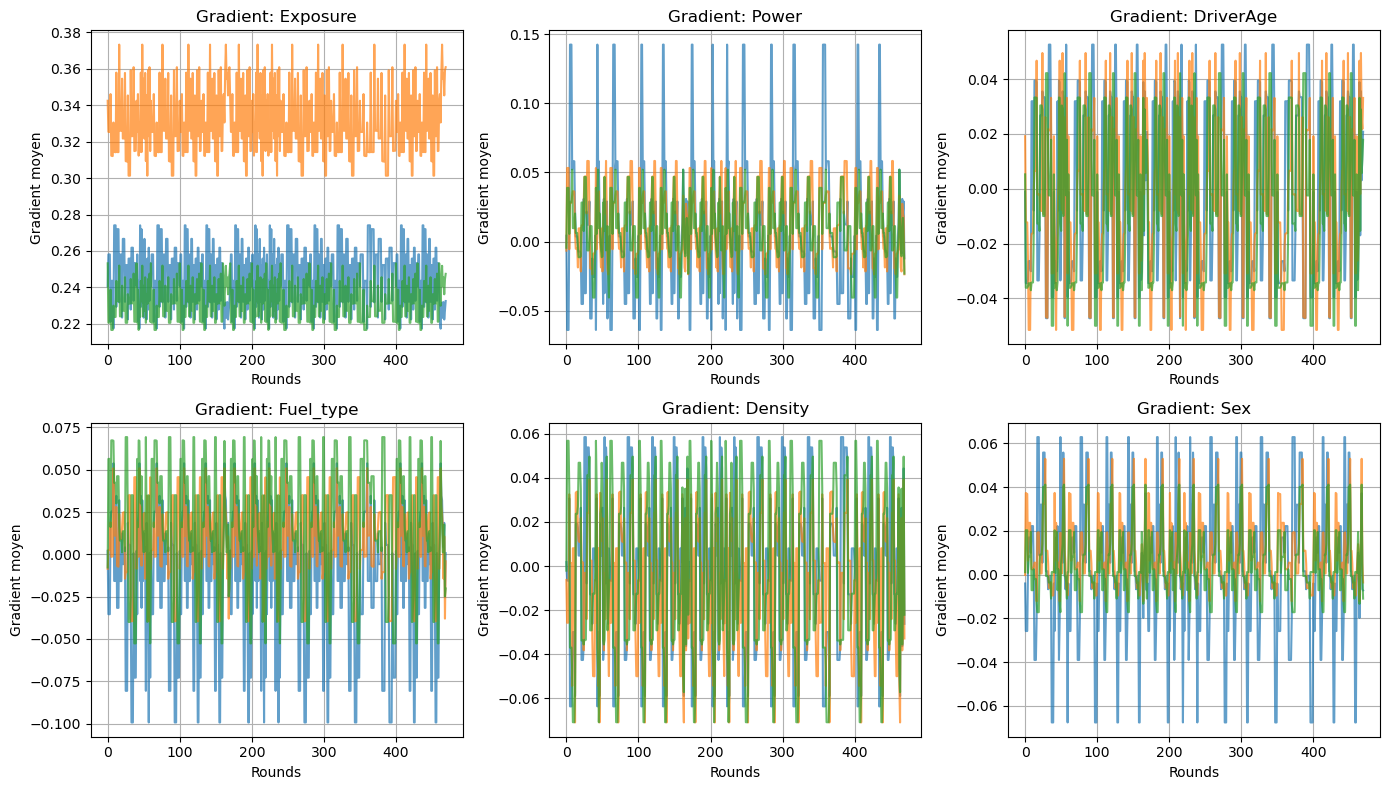


===== OPTIMISATION FEDPROX =====

📊 Round 1/10
   🔹 AUC France: 0.6040
   🔹 AUC Belgique: 0.5752
   🔹 AUC Europe: 0.6365
   🔶 AUC Global: 0.6364
   📈 Exposure: 0.8431
   📈 Power: 0.0021
   📈 DriverAge: -0.1857
   📈 Fuel_type: 0.1010
   📈 Density: 0.1692
   📈 Sex: 0.0183
   📉 Intercept: -0.7722

📊 Round 2/10
   🔹 AUC France: 0.5941
   🔹 AUC Belgique: 0.5512
   🔹 AUC Europe: 0.6375
   🔶 AUC Global: 0.6328
   📈 Exposure: 0.7978
   📈 Power: 0.2007
   📈 DriverAge: -0.1632
   📈 Fuel_type: 0.2109
   📈 Density: -0.1806
   📈 Sex: 0.0354
   📉 Intercept: -0.7984

📊 Round 3/10
   🔹 AUC France: 0.5958
   🔹 AUC Belgique: 0.5432
   🔹 AUC Europe: 0.6312
   🔶 AUC Global: 0.6283
   📈 Exposure: 1.0523
   📈 Power: 0.0654
   📈 DriverAge: -0.0951
   📈 Fuel_type: 0.1285
   📈 Density: -0.2380
   📈 Sex: 0.0015
   📉 Intercept: -0.9238

📊 Round 4/10
   🔹 AUC France: 0.6041
   🔹 AUC Belgique: 0.5302
   🔹 AUC Europe: 0.6288
   🔶 AUC Global: 0.6284
   📈 Exposure: 1.1868
   📈 Power: -0.0584
   📈 DriverAge: 0.1129
 

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import pickle
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Préparation des données (mini-batches stratifiés)
def prepare_client_data(df, n_rounds, features, target="Sinistre", test_size=0.4):
    X = df[features].values
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    scaler = StandardScaler()
    X_train_std = np.hstack([X_train[:, 0:1], scaler.fit_transform(X_train[:, 1:])])
    X_test_std = np.hstack([X_test[:, 0:1], scaler.transform(X_test[:, 1:])])
    idx_class0 = np.where(y_train == 0)[0]
    idx_class1 = np.where(y_train == 1)[0]
    np.random.shuffle(idx_class0)
    np.random.shuffle(idx_class1)
    batch_size_0 = len(idx_class0) // n_rounds
    batch_size_1 = max(1, len(idx_class1) // n_rounds)
    batches = []
    for i in range(n_rounds):
        start0, end0 = i * batch_size_0, min((i + 1) * batch_size_0, len(idx_class0))
        start1, end1 = i * batch_size_1, min((i + 1) * batch_size_1, len(idx_class1))
        batch_indices = np.concatenate([idx_class0[start0:end0], idx_class1[start1:end1] if start1 < len(idx_class1) else []])
        batches.append((X_train_std[batch_indices], y_train[batch_indices]))
    return batches, X_test_std, y_test

# Client avec tracking des gradients
class FLClient:
    def __init__(self, data_batches, client_id, local_epochs=3, algorithm="FedAvg", mu=0.1):
        self.client_id = client_id
        self.batches = data_batches
        self.n_rounds = len(data_batches)
        self.local_epochs = local_epochs
        self.algorithm = algorithm
        self.mu = mu
        self.n_samples = sum(len(batch[0]) for batch in data_batches)
        self.model = SGDClassifier(
            loss="log_loss", penalty="l2", alpha=0.01, learning_rate="constant", eta0=0.01,
            class_weight='balanced', max_iter=1, warm_start=True, random_state=42
        )
        n_features = data_batches[0][0].shape[1]
        self.model.classes_ = np.array([0, 1])
        self.model.coef_ = np.zeros((1, n_features))
        self.model.intercept_ = np.zeros(1)
        self.weight_history = {'coef': [], 'intercept': []}
        self.gradient_history = []
        self.imputer = SimpleImputer(strategy='mean')
    
    def train_local_model(self, global_model, round_idx):
        if global_model is not None:
            self.model.coef_ = np.copy(global_model.coef_)
            self.model.intercept_ = np.copy(global_model.intercept_)
        w_init = np.copy(self.model.coef_)
        b_init = np.copy(self.model.intercept_)
        X_batch, y_batch = self.batches[round_idx]
        if np.isnan(X_batch).any():
            X_batch = self.imputer.fit_transform(X_batch)
        unique_classes = np.unique(y_batch)
        if len(unique_classes) < 2:
            print(f"⚠️ Batch {round_idx} du client {self.client_id} ne contient que la classe {unique_classes[0]}")
            return self.model
        for _ in range(self.local_epochs):
            # Tracking du gradient
            logits = np.dot(X_batch, self.model.coef_.T) + self.model.intercept_
            probs = 1 / (1 + np.exp(-logits)).flatten()
            error = probs - y_batch
            grad_coef = np.dot(X_batch.T, error).reshape(1, -1) / len(y_batch)
            grad_intercept = np.mean(error)
            self.gradient_history.append({'round': round_idx, 'coef_grad': np.copy(grad_coef), 'intercept_grad': grad_intercept})
            # Update
            self.model.partial_fit(X_batch, y_batch, classes=[0, 1])
            if self.algorithm == "FedProx":
                self.model.coef_ -= self.mu * (self.model.coef_ - w_init)
                self.model.intercept_ -= self.mu * (self.model.intercept_ - b_init)
            if abs(self.model.intercept_[0]) > 5:
                self.model.intercept_[0] = np.clip(self.model.intercept_[0], -5, 5)
        self.weight_history['coef'].append(np.copy(self.model.coef_[0]))
        self.weight_history['intercept'].append(np.copy(self.model.intercept_[0]))
        return self.model


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
import matplotlib.pyplot as plt
import os
from datetime import datetime
import copy

# 1. Préparation des données avec stratification des classes
def prepare_client_data(df, n_rounds, features=["Power", "DriverAge", "Fuel_type", "Density", "Sex"], 
                        target="Sinistre", test_size=0.4):
    """Prépare les données client avec des mini-batches équilibrés"""
    X = df[features].values
    y = df[target].values
    exposure = df["Exposure"].values
    
    # Split train/test stratifié
    X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
        X, y, exposure, test_size=test_size, stratify=y, random_state=42
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Créer des mini-batches stratifiés
    indices_class0 = np.where(y_train == 0)[0]
    indices_class1 = np.where(y_train == 1)[0]
    
    np.random.shuffle(indices_class0)
    np.random.shuffle(indices_class1)
    
    batch_size_0 = len(indices_class0) // n_rounds
    batch_size_1 = max(1, len(indices_class1) // n_rounds)  # Au moins 1 exemple positif
    
    batches = []
    for i in range(n_rounds):
        # Sélectionner des indices pour les deux classes
        start0 = i * batch_size_0
        end0 = min((i + 1) * batch_size_0, len(indices_class0))
        
        start1 = i * batch_size_1
        end1 = min((i + 1) * batch_size_1, len(indices_class1))
        
        batch_indices = np.concatenate([
            indices_class0[start0:end0],
            indices_class1[start1:end1] if start1 < len(indices_class1) else []
        ])
        
        X_batch = X_train_std[batch_indices]
        y_batch = y_train[batch_indices]
        exposure_batch = exposure_train[batch_indices]
        
        batches.append((X_batch, y_batch, exposure_batch))
    
    # Entraîner un modèle local pour comparaison
    local_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    local_model.fit(X_train_std, y_train)
    
    return batches, (X_test_std, y_test, exposure_test), (X_train_std, y_train, exposure_train), local_model

# Fonction pour calculer l'indice de Youden
def calculate_youden_index(y_true, y_pred_proba):
    """
    Calcule l'indice de Youden (sensibilité + spécificité - 1) pour différents seuils
    et retourne le seuil optimal avec son indice correspondant.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculer l'indice de Youden pour chaque seuil
    youden_indices = tpr - fpr  # équivalent à: sensibilité + spécificité - 1
    
    # Trouver le seuil optimal (celui qui maximise l'indice de Youden)
    optimal_idx = np.argmax(youden_indices)
    optimal_threshold = thresholds[optimal_idx]
    optimal_youden = youden_indices[optimal_idx]
    
    # Sensibilité et spécificité au seuil optimal
    optimal_sensitivity = tpr[optimal_idx]
    optimal_specificity = 1 - fpr[optimal_idx]
    
    return {
        'threshold': optimal_threshold,
        'youden_index': optimal_youden,
        'sensitivity': optimal_sensitivity,
        'specificity': optimal_specificity,
        'all_thresholds': thresholds,
        'all_youden_indices': youden_indices
    }

# 2. Client de base (parent)
class BaseClient:
    def __init__(self, data_batches, client_id, local_epochs=3):
        """Initialise un client d'apprentissage fédéré"""
        self.client_id = client_id
        self.batches = data_batches
        self.n_rounds = len(data_batches)
        self.local_epochs = local_epochs
        self.n_samples = sum(len(batch[0]) for batch in data_batches)
        
        # Initialiser le modèle avec le contrôle de l'intercept
        self.model = SGDClassifier(
            loss="log_loss",
            penalty="l2",
            alpha=0.01,  # Régularisation L2
            learning_rate="constant",
            eta0=0.01,    # Taux d'apprentissage
            class_weight='balanced',  # Important pour données déséquilibrées
            max_iter=1,
            warm_start=True,
            random_state=42
        )
        
        # Initialisation manuelle des coefficients
        n_features = data_batches[0][0].shape[1]
        self.model.classes_ = np.array([0, 1])
        self.model.coef_ = np.zeros((1, n_features))
        self.model.intercept_ = np.zeros(1)
        
        # Historique des poids
        self.weight_history = {'coef': [], 'intercept': []}
        
        # Historique des pertes
        self.loss_history = []
        
        # Imputer pour gérer les valeurs manquantes
        self.imputer = SimpleImputer(strategy='mean')

# 3. Client FedAvg
class FedAvgClient(BaseClient):
    def train_local_model(self, global_model, round_idx):
        """Entraîne le modèle local avec plusieurs époques sur le batch du round actuel"""
        # Copier les poids du modèle global
        if global_model is not None:
            self.model.coef_ = np.copy(global_model.coef_)
            self.model.intercept_ = np.copy(global_model.intercept_)
        
        # Récupérer le batch pour ce round
        X_batch, y_batch, _ = self.batches[round_idx]
        
        # Vérifier les classes présentes
        unique_classes = np.unique(y_batch)
        if len(unique_classes) < 2:
            print(f"⚠️ Batch {round_idx} du client {self.client_id} contient uniquement la classe {unique_classes[0]}")
            return self.model
        
        # Imputations si nécessaire
        if np.isnan(X_batch).any():
            X_batch = self.imputer.fit_transform(X_batch)
        
        # Entraînement local avec E époques
        for _ in range(self.local_epochs):
            self.model.partial_fit(X_batch, y_batch, classes=[0, 1])
            
            # Stabilisation de l'intercept
            if abs(self.model.intercept_[0]) > 5:
                self.model.intercept_[0] = np.clip(self.model.intercept_[0], -5, 5)
        
        # Calculer la perte finale sur ce batch
        if np.isnan(X_batch).any():
            X_batch_clean = self.imputer.fit_transform(X_batch)
        else:
            X_batch_clean = X_batch

        y_pred = self.model.predict_proba(X_batch_clean)
        batch_loss = log_loss(y_batch, y_pred)
        self.loss_history.append(batch_loss)
        print(f"   📉 Loss {self.client_id} (Round {round_idx+1}): {batch_loss:.4f}")
        
        # Enregistrer les poids après entraînement
        self.weight_history['coef'].append(np.copy(self.model.coef_[0]))
        self.weight_history['intercept'].append(np.copy(self.model.intercept_[0]))
        
        return self.model

# 4. Client FedProx
class FedProxClient(BaseClient):
    def __init__(self, data_batches, client_id, local_epochs=3, mu=0.01):
        super().__init__(data_batches, client_id, local_epochs)
        self.mu = mu  # Coefficient de régularisation proximal
    
    def train_local_model(self, global_model, round_idx):
        """Entraîne le modèle local avec régularisation proximale"""
        # Copier les poids du modèle global
        if global_model is not None:
            self.model.coef_ = np.copy(global_model.coef_)
            self.model.intercept_ = np.copy(global_model.intercept_)
            
            # Sauvegarder une copie des poids globaux pour la régularisation proximale
            global_weights = np.copy(global_model.coef_[0])
            global_intercept = np.copy(global_model.intercept_[0])
        else:
            global_weights = np.zeros_like(self.model.coef_[0])
            global_intercept = 0.0
        
        # Récupérer le batch pour ce round
        X_batch, y_batch, _ = self.batches[round_idx]
        
        # Vérifier les classes présentes
        unique_classes = np.unique(y_batch)
        if len(unique_classes) < 2:
            print(f"⚠️ Batch {round_idx} du client {self.client_id} contient uniquement la classe {unique_classes[0]}")
            return self.model
        
        # Imputations si nécessaire
        if np.isnan(X_batch).any():
            X_batch = self.imputer.fit_transform(X_batch)
        
        # Entraînement local avec terme proximal
        for _ in range(self.local_epochs):
            # Mise à jour standard avec SGD
            self.model.partial_fit(X_batch, y_batch, classes=[0, 1])
            
            # Appliquer la régularisation proximale manuellement
            prox_coef = self.model.coef_[0] - self.mu * (self.model.coef_[0] - global_weights)
            prox_intercept = self.model.intercept_[0] - self.mu * (self.model.intercept_[0] - global_intercept)
            
            self.model.coef_[0] = prox_coef
            self.model.intercept_[0] = prox_intercept
            
            # Stabilisation de l'intercept
            if abs(self.model.intercept_[0]) > 5:
                self.model.intercept_[0] = np.clip(self.model.intercept_[0], -5, 5)
        
        # Calculer la perte finale sur ce batch
        if np.isnan(X_batch).any():
            X_batch_clean = self.imputer.fit_transform(X_batch)
        else:
            X_batch_clean = X_batch

        y_pred = self.model.predict_proba(X_batch_clean)
        batch_loss = log_loss(y_batch, y_pred)
        self.loss_history.append(batch_loss)
        print(f"   📉 Loss {self.client_id} (Round {round_idx+1}): {batch_loss:.4f}")
        
        # Enregistrer les poids après entraînement
        self.weight_history['coef'].append(np.copy(self.model.coef_[0]))
        self.weight_history['intercept'].append(np.copy(self.model.intercept_[0]))
        
        return self.model

# 5. Serveur de base
class BaseServer:
    def __init__(self, clients, feature_names, clip_intercept=True):
        """Initialise le serveur d'agrégation"""
        self.clients = clients
        self.n_rounds = clients[0].n_rounds
        self.feature_names = feature_names
        self.clip_intercept = clip_intercept
        
        # Modèle global
        self.global_model = SGDClassifier(
            loss="log_loss",
            penalty="l2",
            alpha=0.01,
            class_weight='balanced',
            max_iter=1,
            warm_start=True,
            random_state=42
        )
        
        # Initialisation
        n_features = clients[0].batches[0][0].shape[1]
        self.global_model.classes_ = np.array([0, 1])
        self.global_model.coef_ = np.zeros((1, n_features))
        self.global_model.intercept_ = np.zeros(1)
        
        # Historique
        self.weight_history = {'coef': [], 'intercept': []}
        self.auc_history = {client.client_id: [] for client in clients}
        self.auc_history['Global'] = []
        
        # Historique des indices de Youden
        self.youden_history = {client.client_id: [] for client in clients}
        self.youden_history['Global'] = []
    
    def aggregate_models(self, models, weights):
        """Agrège les modèles locaux en modèle global"""
        avg_coef = np.zeros_like(models[0].coef_)
        avg_intercept = np.zeros_like(models[0].intercept_)
        
        total_weight = sum(weights)
        for model, weight in zip(models, weights):
            avg_coef += (weight / total_weight) * model.coef_
            avg_intercept += (weight / total_weight) * model.intercept_
        
        self.global_model.coef_ = avg_coef
        
        # Contrôler l'intercept
        if self.clip_intercept:
            self.global_model.intercept_ = np.clip(avg_intercept, -5, 5)
        else:
            self.global_model.intercept_ = avg_intercept
        
        return self.global_model
    
    def train(self, X_test_dict, y_test_dict, exposure_test_dict):
        """Exécute l'entraînement fédéré et imprime les résultats par round"""
        imputer = SimpleImputer(strategy='mean')
        
        for round_idx in range(self.n_rounds):
            print(f"\n📊 Round {round_idx+1}/{self.n_rounds}")
            
            # Entraînement local
            local_models = []
            weights = []
            
            for client in self.clients:
                local_model = client.train_local_model(self.global_model, round_idx)
                local_models.append(local_model)
                weights.append(len(client.batches[round_idx][0]))
            
            # Agrégation
            self.global_model = self.aggregate_models(local_models, weights)
            
            # Enregistrer les poids globaux
            self.weight_history['coef'].append(np.copy(self.global_model.coef_[0]))
            self.weight_history['intercept'].append(np.copy(self.global_model.intercept_[0]))
            
            # Évaluation par client
            all_y_true = []
            all_y_pred = []
            
            for client in self.clients:
                X_test = X_test_dict[client.client_id]
                y_test = y_test_dict[client.client_id]
                exposure_test = exposure_test_dict[client.client_id]
                
                # Imputation si nécessaire
                if np.isnan(X_test).any():
                    X_test_clean = imputer.fit_transform(X_test)
                else:
                    X_test_clean = X_test
                
                # Prédiction avec le modèle global, ajustée par l'exposition
                y_pred = self.global_model.predict_proba(X_test_clean)[:, 1] * exposure_test
                
                # Calcul de l'AUC
                auc = roc_auc_score(y_test, y_pred)
                self.auc_history[client.client_id].append(auc)
                
                # Calcul de l'indice de Youden
                youden_results = calculate_youden_index(y_test, y_pred)
                self.youden_history[client.client_id].append(youden_results)
                
                print(f"   🔹 AUC {client.client_id}: {auc:.4f}, Youden: {youden_results['youden_index']:.4f} (seuil: {youden_results['threshold']:.4f})")
                
                # Pour AUC global et Youden global
                all_y_true.extend(y_test)
                all_y_pred.extend(y_pred)
            
            # AUC global
            global_auc = roc_auc_score(all_y_true, all_y_pred)
            self.auc_history['Global'].append(global_auc)
            
            # Youden global
            global_youden_results = calculate_youden_index(all_y_true, all_y_pred)
            self.youden_history['Global'].append(global_youden_results)
            
            print(f"   🔶 AUC Global: {global_auc:.4f}, Youden: {global_youden_results['youden_index']:.4f} (seuil: {global_youden_results['threshold']:.4f})")
            
            # Afficher les coefficients
            for i, feature in enumerate(self.feature_names):
                print(f"   📈 {feature}: {self.global_model.coef_[0][i]:.4f}")
            print(f"   📉 Intercept: {self.global_model.intercept_[0]:.4f}")
        
        return self.global_model

# 6. Serveur FedAvg
class FedAvgServer(BaseServer):
    pass  # Hérite directement de BaseServer sans modifications

# 7. Serveur FedOpt
class FedOptServer(BaseServer):
    def __init__(self, clients, feature_names, clip_intercept=True, 
                 server_lr=0.1, beta1=0.9, beta2=0.99, tau=1e-3, optimizer="adam"):
        super().__init__(clients, feature_names, clip_intercept)
        self.server_lr = server_lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.tau = tau
        self.optimizer = optimizer.lower()
        
        # Initialiser les moments pour l'optimisation adaptative
        n_features = clients[0].batches[0][0].shape[1]
        self.m = np.zeros((1, n_features))  # Premier moment
        self.v = np.zeros((1, n_features))  # Second moment
        self.m_intercept = np.zeros(1)
        self.v_intercept = np.zeros(1)
    
    def aggregate_models(self, models, weights):
        """Agrège les modèles locaux avec optimisation adaptative"""
        # Calculer la moyenne pondérée des modèles locaux (comme FedAvg)
        avg_coef = np.zeros_like(models[0].coef_)
        avg_intercept = np.zeros_like(models[0].intercept_)
        
        total_weight = sum(weights)
        for model, weight in zip(models, weights):
            avg_coef += (weight / total_weight) * model.coef_
            avg_intercept += (weight / total_weight) * model.intercept_
        
        # Calculer la différence (delta) entre la moyenne et le modèle global actuel
        delta_coef = avg_coef - self.global_model.coef_
        delta_intercept = avg_intercept - self.global_model.intercept_
        
        # Mettre à jour les moments selon l'optimiseur choisi
        self.m = self.beta1 * self.m + (1 - self.beta1) * delta_coef
        self.m_intercept = self.beta1 * self.m_intercept + (1 - self.beta1) * delta_intercept
        
        if self.optimizer == "adam":
            # Mise à jour Adam
            self.v = self.beta2 * self.v + (1 - self.beta2) * (delta_coef ** 2)
            self.v_intercept = self.beta2 * self.v_intercept + (1 - self.beta2) * (delta_intercept ** 2)
        elif self.optimizer == "yogi":
            # Mise à jour Yogi
            self.v = self.v - (1 - self.beta2) * np.sign(self.v - (delta_coef ** 2)) * (delta_coef ** 2)
            self.v_intercept = self.v_intercept - (1 - self.beta2) * np.sign(self.v_intercept - (delta_intercept ** 2)) * (delta_intercept ** 2)
        elif self.optimizer == "adagrad":
            # Mise à jour Adagrad
            self.v += delta_coef ** 2
            self.v_intercept += delta_intercept ** 2
        
        # Appliquer la mise à jour avec le taux d'apprentissage du serveur
        self.global_model.coef_ = self.global_model.coef_ + self.server_lr * self.m / (np.sqrt(self.v) + self.tau)
        self.global_model.intercept_ = self.global_model.intercept_ + self.server_lr * self.m_intercept / (np.sqrt(self.v_intercept) + self.tau)
        
        # Contrôler l'intercept si nécessaire
        if self.clip_intercept:
            self.global_model.intercept_ = np.clip(self.global_model.intercept_, -5, 5)
        
        return self.global_model

# Fonction pour évaluer les performances croisées des modèles
def evaluate_cross_performance(local_models, global_model, X_test_dict, y_test_dict, exposure_test_dict, results_dir):
    """Évalue les performances croisées des modèles locaux vs. modèle global"""
    
    # Créer un dossier pour les résultats de l'évaluation croisée
    cross_eval_dir = os.path.join(results_dir, "cross_evaluation")
    os.makedirs(cross_eval_dir, exist_ok=True)
    
    # Pour chaque paire (modèle source, données cible)
    results = {}
    
    for source_id, source_model in local_models.items():
        results[source_id] = {}
        
        # Évaluer sur chaque client cible
        for target_id, X_test in X_test_dict.items():
            y_test = y_test_dict[target_id]
            exposure_test = exposure_test_dict[target_id]
            
            # Prédiction avec le modèle local source
            y_pred_local = source_model.predict_proba(X_test)[:, 1] * exposure_test
            local_auc = roc_auc_score(y_test, y_pred_local)
            
            # Prédiction avec le modèle global fédéré
            y_pred_global = global_model.predict_proba(X_test)[:, 1] * exposure_test
            global_auc = roc_auc_score(y_test, y_pred_global)
            
            results[source_id][target_id] = {
                'local_auc': local_auc,
                'global_auc': global_auc
            }
            
            # Générer la courbe ROC comparative
            plt.figure(figsize=(10, 8))
            
            # Courbe ROC du modèle local
            fpr_local, tpr_local, _ = roc_curve(y_test, y_pred_local)
            plt.plot(fpr_local, tpr_local, 'r-', lw=2, 
                    label=f'Modèle {source_id} (AUC = {local_auc:.4f})')
            
            # Courbe ROC du modèle global
            fpr_global, tpr_global, _ = roc_curve(y_test, y_pred_global)
            plt.plot(fpr_global, tpr_global, 'b-', lw=2, 
                    label=f'Modèle Fédéré (AUC = {global_auc:.4f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taux de faux positifs')
            plt.ylabel('Taux de vrais positifs')
            plt.title(f'Comparaison: Modèle {source_id} vs Fédéré sur données {target_id}')
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.savefig(f"{cross_eval_dir}/{source_id}_on_{target_id}.png")
            plt.close()
    
    # Créer un tableau récapitulatif
    with open(f"{cross_eval_dir}/cross_evaluation_summary.txt", "w") as f:
        f.write("Résumé de l'évaluation croisée\n")
        f.write("============================\n\n")
        
        for source_id in results:
            f.write(f"Modèle source: {source_id}\n")
            f.write("-" * 50 + "\n")
            
            for target_id, metrics in results[source_id].items():
                f.write(f"  Sur données {target_id}:\n")
                f.write(f"    AUC modèle local: {metrics['local_auc']:.4f}\n")
                f.write(f"    AUC modèle fédéré: {metrics['global_auc']:.4f}\n")
                f.write(f"    Amélioration: {(metrics['global_auc'] - metrics['local_auc']) * 100:.2f}%\n\n")
    
    return results

# 8. Fonction pour exécuter un algorithme spécifique
def run_algorithm(algorithm, n_rounds, local_epochs, results_dir, **kwargs):
    """Exécute un algorithme d'apprentissage fédéré spécifique et sauvegarde les résultats"""
    print(f"\n🚀 Exécution de {algorithm}...")
    
    # Charger les données
    df_fr = pd.read_csv("../data/french_data.csv").dropna()
    df_be = pd.read_csv("../data/belgium_data.csv").dropna()
    df_eu = pd.read_csv("../data/european_data.csv").dropna()
    
    feature_names = ["Power", "DriverAge", "Fuel_type", "Density", "Sex"]
    
    # Préparer les mini-batches et obtenir les modèles locaux
    fr_batches, (X_fr_test, y_fr_test, exposure_fr_test), (X_fr_train, y_fr_train, exposure_fr_train), fr_local_model = prepare_client_data(df_fr, n_rounds, feature_names)
    be_batches, (X_be_test, y_be_test, exposure_be_test), (X_be_train, y_be_train, exposure_be_train), be_local_model = prepare_client_data(df_be, n_rounds, feature_names)
    eu_batches, (X_eu_test, y_eu_test, exposure_eu_test), (X_eu_train, y_eu_train, exposure_eu_train), eu_local_model = prepare_client_data(df_eu, n_rounds, feature_names)
    
    # Stocker les modèles locaux
    local_models = {
        "France": fr_local_model,
        "Belgique": be_local_model,
        "Europe": eu_local_model
    }
    
    # Initialiser les clients selon l'algorithme
    if algorithm == "FedAvg":
        clients = [
            FedAvgClient(fr_batches, "France", local_epochs),
            FedAvgClient(be_batches, "Belgique", local_epochs),
            FedAvgClient(eu_batches, "Europe", local_epochs)
        ]
        server = FedAvgServer(clients, feature_names)
    elif algorithm == "FedProx":
        mu = kwargs.get('mu', 0.01)
        clients = [
            FedProxClient(fr_batches, "France", local_epochs, mu),
            FedProxClient(be_batches, "Belgique", local_epochs, mu),
            FedProxClient(eu_batches, "Europe", local_epochs, mu)
        ]
        server = FedAvgServer(clients, feature_names)  # FedProx utilise l'agrégation FedAvg
    elif algorithm == "FedOpt":
        clients = [
            FedAvgClient(fr_batches, "France", local_epochs),
            FedAvgClient(be_batches, "Belgique", local_epochs),
            FedAvgClient(eu_batches, "Europe", local_epochs)
        ]
        server = FedOptServer(
            clients, 
            feature_names,
            server_lr=kwargs.get('server_lr', 0.1),
            beta1=kwargs.get('beta1', 0.9),
            beta2=kwargs.get('beta2', 0.99),
            tau=kwargs.get('tau', 1e-3),
            optimizer=kwargs.get('optimizer', 'adam')
        )
    else:
        raise ValueError(f"Algorithme {algorithm} non reconnu")
    
    # Préparer les dictionnaires de test
    X_test_dict = {
        "France": X_fr_test,
        "Belgique": X_be_test,
        "Europe": X_eu_test
    }
    y_test_dict = {
        "France": y_fr_test,
        "Belgique": y_be_test,
        "Europe": y_eu_test
    }
    exposure_test_dict = {
        "France": exposure_fr_test,
        "Belgique": exposure_be_test,
        "Europe": exposure_eu_test
    }
    
    # Entraîner le modèle
    global_model = server.train(X_test_dict, y_test_dict, exposure_test_dict)
    
    # Créer un dossier pour cet algorithme
    algo_dir = os.path.join(results_dir, algorithm)
    os.makedirs(algo_dir, exist_ok=True)
    
    # Sauvegarder les résultats
    np.save(f"{algo_dir}/weights.npy", {
        'coef': server.weight_history['coef'],
        'intercept': server.weight_history['intercept']
    })
    np.save(f"{algo_dir}/auc.npy", server.auc_history)
    
    # Sauvegarder les indices de Youden dans un fichier texte
    with open(f"{algo_dir}/youden_indices.txt", "w") as f:
        f.write(f"Indices de Youden pour {algorithm}\n")
        f.write("=" * 50 + "\n\n")
        
        # Écrire les indices de Youden pour chaque round et chaque client
        for round_idx in range(n_rounds):
            f.write(f"Round {round_idx+1}/{n_rounds}\n")
            f.write("-" * 30 + "\n")
            
            for client_id in server.youden_history:
                if round_idx < len(server.youden_history[client_id]):
                    youden_data = server.youden_history[client_id][round_idx]
                    f.write(f"{client_id}:\n")
                    f.write(f"  Indice de Youden: {youden_data['youden_index']:.4f}\n")
                    f.write(f"  Seuil optimal: {youden_data['threshold']:.4f}\n")
                    f.write(f"  Sensibilité: {youden_data['sensitivity']:.4f}\n")
                    f.write(f"  Spécificité: {youden_data['specificity']:.4f}\n\n")
            
            f.write("\n")
    
    # Générer et sauvegarder les graphiques
    # 1. Évolution des poids
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(12, 6))
        
        # Poids globaux
        global_weights = [coef[i] for coef in server.weight_history['coef']]
        plt.plot(range(1, len(global_weights)+1), global_weights, 'r-o', linewidth=2, label='Global')
        
        # Poids locaux
        for client in clients:
            client_weights = [coef[i] for coef in client.weight_history['coef']]
            plt.plot(range(1, len(client_weights)+1), client_weights, '-o', linewidth=2, label=client.client_id)
        
        plt.xlabel('Rounds')
        plt.ylabel('Valeur du poids')
        plt.title(f'{algorithm} - Évolution du poids pour {feature}')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{algo_dir}/weight_{feature}.png")
        plt.close()
    
    # 2. Évolution de l'intercept
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(server.weight_history['intercept'])+1), 
            server.weight_history['intercept'], 'r-o', linewidth=2, label='Global')
    
    for client in clients:
        plt.plot(range(1, len(client.weight_history['intercept'])+1), 
                client.weight_history['intercept'], '-o', linewidth=2, label=client.client_id)
    
    plt.xlabel('Rounds')
    plt.ylabel('Valeur de l\'intercept')
    plt.title(f'{algorithm} - Évolution de l\'intercept')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{algo_dir}/intercept.png")
    plt.close()
    
    # 3. Évolution de l'AUC
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(server.auc_history['Global'])+1), 
            server.auc_history['Global'], 'k-o', linewidth=2, label='Global')
    
    for client_id, aucs in server.auc_history.items():
        if client_id != 'Global':
            plt.plot(range(1, len(aucs)+1), aucs, '-o', linewidth=2, label=client_id)
    
    plt.xlabel('Rounds')
    plt.ylabel('AUC Score')
    plt.title(f'{algorithm} - Évolution de l\'AUC')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{algo_dir}/auc.png")
    plt.close()
    
    # 4. Évolution de l'indice de Youden
    plt.figure(figsize=(12, 6))
    youden_values_global = [data['youden_index'] for data in server.youden_history['Global']]
    plt.plot(range(1, len(youden_values_global)+1), 
            youden_values_global, 'k-o', linewidth=2, label='Global')
    
    for client_id in server.youden_history:
        if client_id != 'Global':
            youden_values = [data['youden_index'] for data in server.youden_history[client_id]]
            plt.plot(range(1, len(youden_values)+1), youden_values, '-o', linewidth=2, label=client_id)
    
    plt.xlabel('Rounds')
    plt.ylabel('Indice de Youden')
    plt.title(f'{algorithm} - Évolution de l\'indice de Youden')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{algo_dir}/youden_index.png")
    plt.close()
    
    # 5. Évolution de la loss par client
    plt.figure(figsize=(12, 6))
    for client in clients:
        plt.plot(range(1, len(client.loss_history)+1), client.loss_history, '-o', linewidth=2, label=client.client_id)

    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.title(f'{algorithm} - Évolution de la fonction de perte')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{algo_dir}/client_loss.png")
    plt.close()
    
    # 6. Courbes ROC finales (globale)
    plt.figure(figsize=(10, 8))
    for client_id, X_test in X_test_dict.items():
        y_test = y_test_dict[client_id]
        exposure_test = exposure_test_dict[client_id]
        imputer = SimpleImputer(strategy='mean')
        
        if np.isnan(X_test).any():
            X_test = imputer.fit_transform(X_test)
            
        y_pred = global_model.predict_proba(X_test)[:, 1] * exposure_test
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        
        plt.plot(fpr, tpr, lw=2, 
                 label=f'{client_id} (AUC = {roc_auc_score(y_test, y_pred):.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'{algorithm} - Courbes ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f"{algo_dir}/roc_curves.png")
    plt.close()
    
    # 7. Courbes ROC par client (comparaison modèle local vs fédéré)
    for client_id in X_test_dict.keys():
        plt.figure(figsize=(10, 8))
        
        X_test = X_test_dict[client_id]
        y_test = y_test_dict[client_id]
        exposure_test = exposure_test_dict[client_id]
        
        # Imputation si nécessaire
        imputer = SimpleImputer(strategy='mean')
        if np.isnan(X_test).any():
            X_test = imputer.fit_transform(X_test)
        
        # Prédictions avec le modèle fédéré
        y_pred_fed = global_model.predict_proba(X_test)[:, 1] * exposure_test
        fpr_fed, tpr_fed, _ = roc_curve(y_test, y_pred_fed)
        auc_fed = roc_auc_score(y_test, y_pred_fed)
        
        # Prédictions avec le modèle local
        local_model = local_models[client_id]
        y_pred_local = local_model.predict_proba(X_test)[:, 1] * exposure_test
        fpr_local, tpr_local, _ = roc_curve(y_test, y_pred_local)
        auc_local = roc_auc_score(y_test, y_pred_local)
        
        # Tracer les courbes
        plt.plot(fpr_fed, tpr_fed, 'b-', lw=2, 
                 label=f'Modèle fédéré (AUC = {auc_fed:.4f})')
        plt.plot(fpr_local, tpr_local, 'r-', lw=2, 
                 label=f'Modèle local (AUC = {auc_local:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title(f'{algorithm} - Comparaison des courbes ROC pour {client_id}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig(f"{algo_dir}/roc_comparison_{client_id}.png")
        plt.close()
    
    # Évaluation croisée des performances
    evaluate_cross_performance(local_models, global_model, X_test_dict, y_test_dict, exposure_test_dict, algo_dir)
    
    return global_model, server, local_models

# 9. Fonction principale pour exécuter tous les algorithmes
def run_all_algorithms(n_rounds=10, local_epochs=3):
    """Exécute tous les algorithmes d'apprentissage fédéré et sauvegarde les résultats"""
    # Créer un dossier pour les résultats
    results_dir = f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(results_dir, exist_ok=True)
    
    # Exécuter FedAvg
    fedavg_model, fedavg_server, fedavg_local_models = run_algorithm("FedAvg", n_rounds, local_epochs, results_dir)
    
    # Exécuter FedProx avec différentes valeurs de mu
    fedprox_model, fedprox_server, fedprox_local_models = run_algorithm("FedProx", n_rounds, local_epochs, results_dir, mu=0.01)
    
    # Exécuter FedOpt avec Adam
    fedopt_model, fedopt_server, fedopt_local_models = run_algorithm(
        "FedOpt", 
        n_rounds, 
        local_epochs, 
        results_dir,
        server_lr=0.1,
        optimizer="adam"
    )
    
    # Créer un graphique comparatif des AUC globales
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, n_rounds+1), fedavg_server.auc_history['Global'], 'r-o', linewidth=2, label='FedAvg')
    plt.plot(range(1, n_rounds+1), fedprox_server.auc_history['Global'], 'g-o', linewidth=2, label='FedProx')
    plt.plot(range(1, n_rounds+1), fedopt_server.auc_history['Global'], 'b-o', linewidth=2, label='FedOpt')
    
    plt.xlabel('Rounds')
    plt.ylabel('AUC Global')
    plt.title('Comparaison des AUC globales entre les algorithmes')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{results_dir}/comparison_auc.png")
    plt.close()
    
    # Créer un graphique comparatif des indices de Youden globaux
    plt.figure(figsize=(12, 6))
    youden_values_fedavg = [data['youden_index'] for data in fedavg_server.youden_history['Global']]
    youden_values_fedprox = [data['youden_index'] for data in fedprox_server.youden_history['Global']]
    youden_values_fedopt = [data['youden_index'] for data in fedopt_server.youden_history['Global']]
    
    plt.plot(range(1, n_rounds+1), youden_values_fedavg, 'r-o', linewidth=2, label='FedAvg')
    plt.plot(range(1, n_rounds+1), youden_values_fedprox, 'g-o', linewidth=2, label='FedProx')
    plt.plot(range(1, n_rounds+1), youden_values_fedopt, 'b-o', linewidth=2, label='FedOpt')
    
    plt.xlabel('Rounds')
    plt.ylabel('Indice de Youden Global')
    plt.title('Comparaison des indices de Youden globaux entre les algorithmes')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{results_dir}/comparison_youden.png")
    plt.close()
    
    # Sauvegarder les paramètres de l'expérience
    with open(f"{results_dir}/parameters.txt", "w") as f:
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Nombre de rounds: {n_rounds}\n")
        f.write(f"Époques locales: {local_epochs}\n")
        f.write(f"FedProx mu: 0.01\n")
        f.write(f"FedOpt optimizer: adam\n")
        f.write(f"FedOpt server_lr: 0.1\n")
    
    # Sauvegarder une comparaison des indices de Youden finaux
    with open(f"{results_dir}/final_youden_comparison.txt", "w") as f:
        f.write("Comparaison des indices de Youden finaux\n")
        f.write("=" * 50 + "\n\n")
        
        # Pour chaque client et global
        for client_id in fedavg_server.youden_history:
            f.write(f"{client_id}:\n")
            f.write("-" * 30 + "\n")
            
            # Récupérer les derniers indices de Youden pour chaque algorithme
            if fedavg_server.youden_history[client_id]:
                youden_fedavg = fedavg_server.youden_history[client_id][-1]
                f.write(f"FedAvg:\n")
                f.write(f"  Indice de Youden: {youden_fedavg['youden_index']:.4f}\n")
                f.write(f"  Seuil optimal: {youden_fedavg['threshold']:.4f}\n")
                f.write(f"  Sensibilité: {youden_fedavg['sensitivity']:.4f}\n")
                f.write(f"  Spécificité: {youden_fedavg['specificity']:.4f}\n\n")
            
            if fedprox_server.youden_history[client_id]:
                youden_fedprox = fedprox_server.youden_history[client_id][-1]
                f.write(f"FedProx:\n")
                f.write(f"  Indice de Youden: {youden_fedprox['youden_index']:.4f}\n")
                f.write(f"  Seuil optimal: {youden_fedprox['threshold']:.4f}\n")
                f.write(f"  Sensibilité: {youden_fedprox['sensitivity']:.4f}\n")
                f.write(f"  Spécificité: {youden_fedprox['specificity']:.4f}\n\n")
            
            if fedopt_server.youden_history[client_id]:
                youden_fedopt = fedopt_server.youden_history[client_id][-1]
                f.write(f"FedOpt:\n")
                f.write(f"  Indice de Youden: {youden_fedopt['youden_index']:.4f}\n")
                f.write(f"  Seuil optimal: {youden_fedopt['threshold']:.4f}\n")
                f.write(f"  Sensibilité: {youden_fedopt['sensitivity']:.4f}\n")
                f.write(f"  Spécificité: {youden_fedopt['specificity']:.4f}\n\n")
            
            f.write("\n")
    
    return results_dir

# Exécution du programme
if __name__ == "__main__":
    results_dir = run_all_algorithms(n_rounds=4, local_epochs=3)
    print(f"Résultats disponibles dans: {results_dir}")



🚀 Exécution de FedAvg...

📊 Round 1/4
   📉 Loss France (Round 1): 0.6836
   📉 Loss Belgique (Round 1): 0.6376
   📉 Loss Europe (Round 1): 0.6870
   🔹 AUC France: 0.6039, Youden: 0.1706 (seuil: 0.2335)
   🔹 AUC Belgique: 0.5673, Youden: 0.0966 (seuil: 0.4429)
   🔹 AUC Europe: 0.6286, Youden: 0.2053 (seuil: 0.2445)
   🔶 AUC Global: 0.6303, Youden: 0.2069 (seuil: 0.2452)
   📈 Power: -0.0474
   📈 DriverAge: -0.1669
   📈 Fuel_type: -0.0122
   📈 Density: 0.1200
   📈 Sex: -0.1808
   📉 Intercept: -0.0721

📊 Round 2/4
   📉 Loss France (Round 2): 0.6775
   📉 Loss Belgique (Round 2): 0.6442
   📉 Loss Europe (Round 2): 0.6927
   🔹 AUC France: 0.6001, Youden: 0.1685 (seuil: 0.2228)
   🔹 AUC Belgique: 0.5613, Youden: 0.0911 (seuil: 0.4699)
   🔹 AUC Europe: 0.6296, Youden: 0.2060 (seuil: 0.2391)
   🔶 AUC Global: 0.6298, Youden: 0.2072 (seuil: 0.2523)
   📈 Power: 0.0383
   📈 DriverAge: -0.1097
   📈 Fuel_type: -0.0396
   📈 Density: 0.0580
   📈 Sex: -0.0885
   📉 Intercept: -0.0472

📊 Round 3/4
   📉 Los

In [79]:
------------------------------------

SyntaxError: invalid syntax (310898216.py, line 1)

Dossiers de résultats créés: ./fl_results_20250505_162025
Dossiers de résultats créés: ./fl_results_20250505_162025
🚀 Exécution de FedAvg...

📊 Round 1/20
   🔹 AUC France: 0.6007
   🔹 AUC Belgique: 0.5608
   🔹 AUC Europe: 0.6301
   🔶 AUC Global: 0.6301

📊 Round 2/20
   🔹 AUC France: 0.6007
   🔹 AUC Belgique: 0.5610
   🔹 AUC Europe: 0.6304
   🔶 AUC Global: 0.6303

📊 Round 3/20
   🔹 AUC France: 0.6008
   🔹 AUC Belgique: 0.5617
   🔹 AUC Europe: 0.6306


KeyboardInterrupt: 